# **Replication 개념**

**Broker에 장애가 발생하면?**


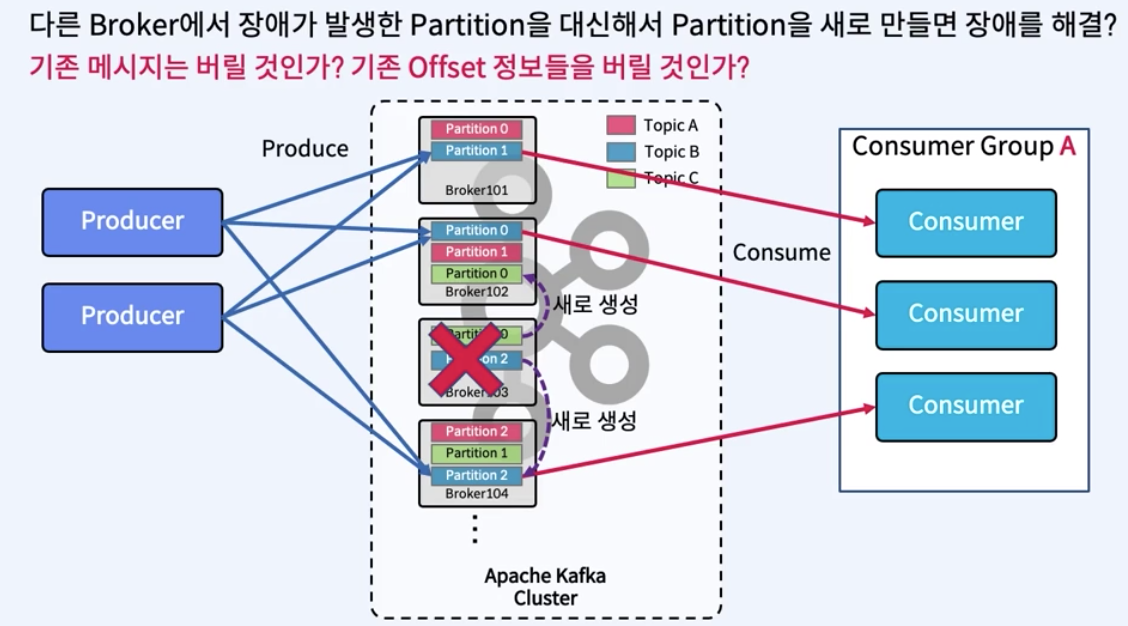

**Replication Of Partition**

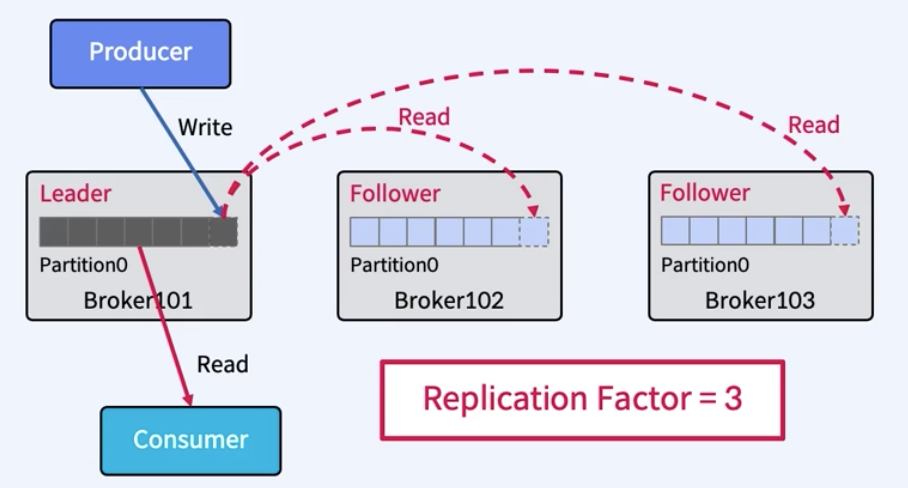

* 장애를 대비하기 위한 기술
* Partition을 복제하여 다른 Broker상에서 복제물을 만들어서 장애를 미리 대비함
* Replicas - Leader, Follower
* Producer는 Leader에만 Write하고 Consumer는 Leader로부터만 Read함
* Follower는 Broker 장애시 안정성을 제공하기 위해서만 존재
* Follower는 Leader의 Commit Log에서 데이터를 가져오기 요청(Fetch Request)으로 복제
* Leader에 장애가 발생하면 복사한 Follower 중에서 새로운 Leader 선출, Client는 자동으로 새 Leader 

**Partition Leader에 대한 자동 분산 (Hot Spot 방지)**


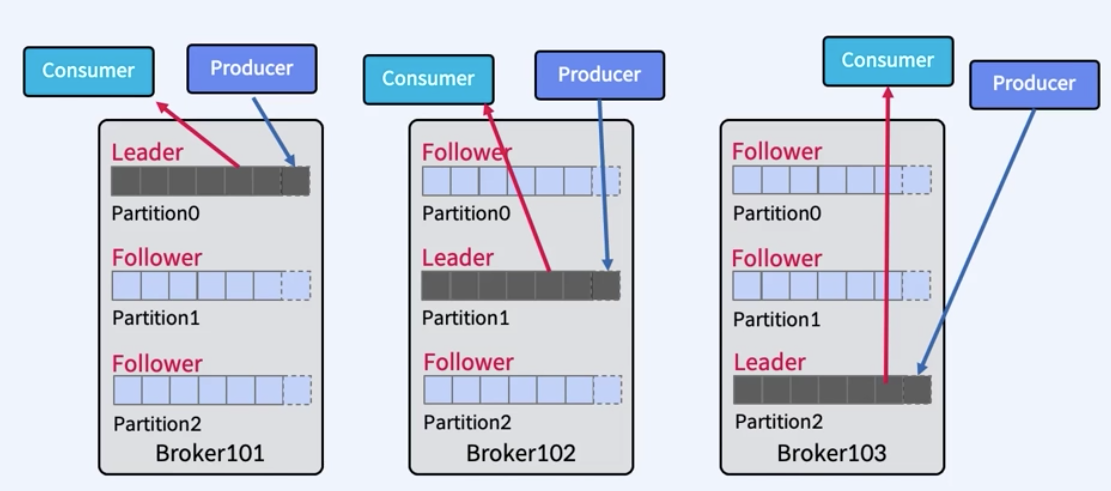

* 하나의 Broker에만 Partition의 leader들이 몰려 있다면 특정 Broker에만 Client로 인해 부하 집중 (Hot Spot)
* 관련 설정값
 - auto.leader.rebalance.enable : 기본값 enable
 * leader.imbalance.check.interval.seconds : 기본값 300 sec
 * leader.imbalance.per.broker.percentage : 기본값 10

**Rack Awareness**

* 복제본은(Replica Leader/Follower) Rack 간 분산하여 Rack 장애를 대비.
* 동일한 Rack 혹은 Available Zone 상의 Broker들에 동일한 "rack name" 지정.
* Topic 생성시 또는 Auto Data Balancer/Self Balancing Cluster 동작 때만 실행.

# **In-Sync Replicas(ISR)**

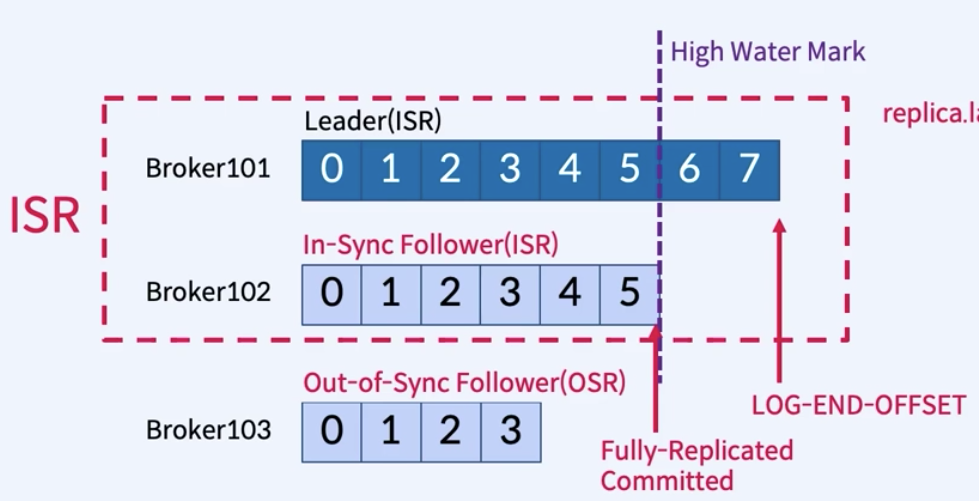

* Leader에 장애가 났을 때 Follower 중 어떤 것을 선택할지 고르는 지표 (잘 복사하고 있는지)
* ISR은 High Water Mark라고 하는 지점까지 동일한 Replicas(Leader와 Follwer)의 목록
* replica.lag.max.message 값(뒤떨어지는 최대치?)으로 ISR을 판단하여 ISR 중에 Leader로 선정함

**replica.lag.max.messages로 ISR 판단시 문제점**

* 메시지가 항상 일정한 비율로 들어올때는 ISR들이 정상적으로 동작
* 메시지 유입량이 갑자기 늘어날 경우, 지연으로 판단하고 OSR(Out-of-Sync Replica)로 상태를 변경
* 실제로는 정상적으로 동작하고 단지 잠깐 지연만 발생했을 뿐인데, 해당 옵션을 이용하면 불필요한 error 발생 및 그로 인한 불필요한 retry 유발
* relica.lag.time.max.ms로 판단해야함
 - Follower가 Leader로 Fetch 요청을 보내는 Interval 체크
 * 해당값이 10000이라면 Follower가 Leaderfh Fetch 요청을 10000ms 내에만 요청하면 정상으로 판단.
 * 특정 어플리케이션에는 해당 파라미터만 제공

**ISR은 Leader가 속해있는 브로커가 관리**

* Follower가 너무 느리면 Leader는 ISR에서 Follower을 제거하고 ZooKeeper에 ISR 유지
* Controller는 Partition Metadata에 대한 변경 사항에 대해서 ZooKeeper로부터 수신

**Controller란**
* Kafka Cluster 내의 Broker 중 하나가 Controller가 됨.
* Controller는 ZooKeeper를 통해 Broker Liveness를 모니터링
* Controller는 Leader와 Replica 정보를 CLuster내의 다른 Broker들에게 전달
* Controller는 ZooKeeper에 Relicas 정보의 복사본을 유지한 다음 더 빠른 엑세스를 위해 클러스터의 모든 Broker들에게 동일한 정보를 캐시함.
* Controller의 Leader 장애시 Leader Election을 수행
* Controller가 장애가 나면 다른 Active Broker들 중에서 재선출됨.

**Consumer 관련 포지션들**

* Last Commited Offset(Current Offset) : Consumer가 최종 Commit한 OffSet
* Current Position : Consumer가 읽어간 위치(처리중, Commit전)
* High water mark(Commited) : ISR 간에 복제된 Offset
* Log End Offset : Producer가 메시지를 보내서 저장된, 로그의 맨 끝 Offset
* Consumer lag : Last Commited Offset <--> Log End Offset 간의 차이

**Commited란**

* ISR 목록의 모든 Replicas가 메시지를 받으면 Commited
* Consumer는 Commited 메시지만 읽을 수 있음
* Leader는 메시지를 Commit할 시기를 결정
* Committed 메시지는 모든 Follower에서 동일한 Offset을 갖도록 보장
* 즉, 어떤 Replic가 Leader인지에 관계없이 모든 Consumer는 해당 Offset에서 같은 데이터를 볼 수 있음.
* Broker가 다시 시작할 때 Commited 메시지 목록을 유지하도록 하기 위해, Broker의 모든 Partition에 대한 마지막 Committed Offset은 replication-Offset-checkPoint라는 파일에 기록됨.
**Replicas 동기화**
* High Water Mark
 - 가장 최근의 Committed메시지의 Offset 추적
 - replication-offset-checkpoint 파일에 체크포인트를 기록
* Leader Epoch
 - 새 Leader가 선출된 시점을 Offset으로 표시
 - Broker 복구 중에 메시지를 체크포인트로 자른 다음 현재 Leader를 따르기 위해 사용됨
 - Controller가 새 Leader를 선택하면 Leader Epoch를 업데이트하고 해당 정보를 ISR 목록의 모든 구성원에게 보냄
 - Leader-epoch-checkpoint 파일에 체크포인트를 기록

**Message Commit 과정**

* Offset5 까지 복제가 완료되어 있는 상황에서, Producer가 메시지를 보내면 Leader가 Offset6에 새 메시지를 추가
* 각 Follower 들의 Fetcher Thread가 독립적으로 fetch를 수행하고, 가져온 메시지를 Offset6에 메시지 write
* 각 Follower 들의 Fetcher Thread가 독립적으로 다시 fetch를 수행하고 null을 받음. Leader는 High Water Mark 이동
* 각 Follower 들의 Fetcher Thread가 독립적으로 다시 fetch를 수행하고 High Water Mark를 받음, 업데이트

\\